In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [4]:
!nvidia-smi

Mon Oct 14 23:10:26 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.116                Driver Version: 390.116                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
| 61%   66C    P0    77W / 250W |    235MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
torch.cuda.set_device(0)

In [6]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-hindi/language-model


In [7]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-hindi/language-model')

In [10]:
# train_files, test_files = train_test_split(files, test_size=0.2)

In [11]:
# len(train_files), len(test_files)

In [12]:
# str(train_files[0]).split('/')[-1][:-4]

In [13]:
# # Preparing dataset for fastai
# for file in train_files:
#     with open(file, 'rb') as f:
#         text = pickle.load(f)
#     with open(path/'hindi_transformer'/'train'/(str(file).split('/')[-1][:-4]+'.txt'), "w") as text_file:
#         text_file.write(text)

In [14]:
# for file in test_files:
#     with open(file, 'rb') as f:
#         text = pickle.load(f)
#     with open(path/'hindi_transformer'/'valid'/(str(file).split('/')[-1][:-4]+'.txt'), "w") as text_file:
#         text_file.write(text)

In [15]:
# from inltk.tokenizer import HindiTokenizer

In [16]:
# HindiTokenizer

In [17]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-hindi/language-model')

In [18]:
class HindiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/hindi_lm_large.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [19]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/hindi_lm_large.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [20]:
len(itos)

30000

In [21]:
itos[:20]

['<unk>',
 '<s>',
 '</s>',
 '▁के',
 '।',
 '▁में',
 '▁है',
 ',',
 '▁की',
 '▁',
 '▁और',
 '▁से',
 '▁का',
 '▁को',
 '▁हैं',
 '▁एक',
 '▁पर',
 '.',
 '-',
 '▁ने']

In [22]:
# 30,000 is the vocab size that we chose in sentencepiece
hindi_vocab = Vocab(itos)

In [23]:
tokenizer = Tokenizer(tok_func=HindiTokenizer, lang='hi')

In [24]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [25]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-hindi/language-model')

In [26]:
data_lm = TextLMDataBunch.from_folder(path=path/'hindi_transformer', tokenizer=tokenizer, vocab=hindi_vocab)

In [27]:
data_lm.batch_size

64

In [28]:
data_lm.save()

In [29]:
data_lm.show_batch()

idx,text
0,"▁जे स्टन ▁जेम्स ▁बॉण्ड ▁1953 ▁में ▁अंग्रेज़ ▁लेखक ▁इयान ▁फ़्लेम िंग ▁द्वारा ▁रचित ▁एक ▁काल्पनिक ▁पात्र ▁है । ▁007 ▁के ▁गुप्त ▁नाम ▁से ▁प्रसिद्ध ▁यह ▁एजेंट ▁फ़्लेम िंग ▁की ▁बारह ▁पुस्तकों ▁व ▁दो ▁लघुकथा ओं ▁में ▁मौजूद ▁है । ▁1964 ▁में ▁फ़्लेम िंग ▁की ▁मृत्यु ▁के ▁पश्चात ▁छः ▁अन्य ▁लेखकों ▁ने ▁बॉण्ड ▁की ▁आधि कृत ▁पुस्तकें ▁लिखी ▁हैं , ▁जिनमें ▁किंग्स ले ▁ऐ मिस , ▁क्रिस्टोफ़र ▁वुड्स , ▁जॉन ▁गार्ड"
1,"▁जो ▁क ल्हण ▁द्वारा ▁12 वीं ▁शताब्दी ▁ई . ▁में ▁लिखा ▁गया ▁था । ▁तब ▁तक ▁यहां ▁पूर्ण ▁हिन्दू ▁राज्य ▁रहा ▁था । यह ▁अशोक ▁महान ▁के ▁साम्राज्य ▁का ▁हिस्सा ▁भी ▁रहा । ▁लगभग ▁तीसरी ▁शताब्दी ▁में ▁अशोक ▁का ▁शासन ▁रहा ▁था । ▁तभी ▁यहां ▁बौद्ध ▁धर्म ▁का ▁आगमन ▁हुआ , ▁जो ▁आगे ▁चलकर ▁कुषाण ों ▁के ▁अधीन ▁सम ृ ध्द ▁हुआ ▁था । उ ज्ज ैन ▁के ▁महाराज ▁विक्रमादित्य"
2,"▁पाकिस्तान ▁शामिल ▁हैं ▁जबकि ▁भारी ▁मात्रा ▁में ▁कैन ोला ▁ऑयल ▁और ▁मील ▁संयुक्त ▁राज्य ▁अमेरिका ▁जाता ▁है ▁और ▁इसकी ▁छोटी ▁मात्रा एं ▁मैक्सिको , ▁चीन ▁और ▁यूरोप ▁में ▁भेज ▁दी ▁जाती ▁हैं । ▁वर्ष ▁2002 - 2003 ▁के ▁मौसम ▁में ▁दुनिया ▁भर ▁में ▁लगभग ▁14 ▁मिलियन ▁मैट्रिक ▁टन ▁रे प सीड ▁ऑयल ▁का ▁उत्पादन ▁हुआ ▁था । ▁कैन ोला ▁को ▁पारंपरिक ▁पौध ▁प्रजनन ▁के ▁जरिये ▁रे प सीड ▁से ▁विकसित"
3,"▁फिल्मों ▁में ▁दिखी ं । ▁पहले ▁अभिषेक ▁कपूर ▁की ▁फि तूर ▁में ▁जो ▁चार्ल्स ▁डिकेंस ▁के ▁उपन्यास ▁ग्रेट ▁एक्स्प ेक्ट ै शन ▁पर ▁आधारित ▁थी । ▁फिल्म ▁में ▁आदित्य ▁रॉय ▁कपूर ▁और ▁तब ु ▁भी ▁थे । ▁बाद ▁में ▁बार ▁बार ▁देखो ▁में ▁वह ▁सिद्धार्थ ▁मल्होत्रा ▁के ▁साथ ▁नज़र ▁आई । ▁दोनों ▁ही ▁फिल्म ▁सफल ▁नहीं ▁रही । ▁हिन्दुस्तान ▁के ▁विशाल ▁ठाकुर ▁ने ▁लिखा : ▁"" बार ▁बार ▁देखो ▁में"
4,"▁नहीं ▁आते ▁हैं , ▁जबकि ▁मु वत् ता ▁के ▁सभी ▁हदीस ▁अन्य ▁सही ह ▁किताबों ▁में ▁शामिल ▁हैं । ▁सुन्नी ▁मुस्लिम ▁छह ▁प्रमुख ▁हदीस ▁संग्रह ों ▁को ▁उनके ▁सबसे ▁महत्वपूर्ण ▁मानते ▁हैं , ▁हालांकि ▁प्रामाणिकता ▁का ▁क्रम ▁मज़ ह ब ों ▁के ▁बीच ▁भिन्न ▁होता ▁है ▁इब्न ▁हज र ▁के ▁अनुसार , ▁पहले ▁दो , ▁जिसे ▁आमतौर ▁पर ▁दो ▁सह हि ह ▁के ▁रूप ▁में ▁जाना ▁जाता ▁है , ▁उनकी"


In [35]:
??language_model_learner

In [30]:
len(data_lm.vocab.itos)

30000

In [31]:
learn = language_model_learner(data_lm, TransformerXL, pretrained=False)

In [32]:
gc.collect()

20

In [33]:
learn.model

SequentialRNN(
  (0): TransformerXL(
    (encoder): Embedding(30000, 410)
    (pos_enc): PositionalEncoding()
    (drop_emb): Dropout(p=0.1)
    (layers): ModuleList(
      (0): DecoderLayer(
        (mhra): MultiHeadRelativeAttention(
          (attention): Linear(in_features=410, out_features=1230, bias=False)
          (out): Linear(in_features=410, out_features=410, bias=False)
          (drop_att): Dropout(p=0.1)
          (drop_res): Dropout(p=0.1)
          (ln): LayerNorm(torch.Size([410]), eps=1e-05, elementwise_affine=True)
          (r_attn): Linear(in_features=410, out_features=410, bias=False)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=410, out_features=2100, bias=True)
            (1): ReLU(inplace)
            (2): Dropout(p=0.1)
            (3): Linear(in_features=2100, out_features=410, bias=True)
            (4): Dropout(p=0.1)
            (5): MergeLayer()
            (6): LayerNorm(torch.Size([410]), eps

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


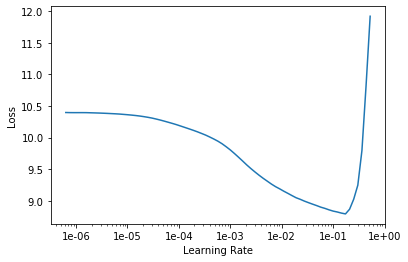

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='model')])

epoch,train_loss,valid_loss,accuracy,time
0,5.074192,5.015274,0.260868,1:25:33
1,4.412691,4.317023,0.317931,1:25:35
2,4.188562,4.081395,0.333240,1:25:59
3,4.096096,4.047993,0.331070,1:26:10
4,4.091798,4.032840,0.328847,1:26:03
5,4.044764,4.007892,0.329269,1:25:37
6,4.046127,3.945281,0.335464,1:25:58
7,3.919419,3.886997,0.340124,1:26:16
8,3.838495,3.820855,0.347243,1:26:22
9,3.836525,3.766215,0.352727,1:26:20


Better model found at epoch 0 with accuracy value: 0.2608684301376343.
Better model found at epoch 1 with accuracy value: 0.31793108582496643.
Better model found at epoch 2 with accuracy value: 0.3332400619983673.
Better model found at epoch 6 with accuracy value: 0.3354644179344177.
Better model found at epoch 7 with accuracy value: 0.34012407064437866.
Better model found at epoch 8 with accuracy value: 0.34724289178848267.
Better model found at epoch 9 with accuracy value: 0.35272735357284546.
Better model found at epoch 10 with accuracy value: 0.35819557309150696.
Better model found at epoch 11 with accuracy value: 0.36840856075286865.
Better model found at epoch 12 with accuracy value: 0.37550199031829834.
Better model found at epoch 13 with accuracy value: 0.3849523663520813.
Better model found at epoch 14 with accuracy value: 0.3937096893787384.
Better model found at epoch 15 with accuracy value: 0.40219518542289734.
Better model found at epoch 16 with accuracy value: 0.408734261

In [37]:
TEXT = "जिसके लिये उन्हें "
N_WORDS = 40
N_SENTENCES = 2

In [38]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

जिसके लिये उन्हें  ▁बर्मी ▁अथवा ▁चो शि यु ▁भी ▁कहा ▁जाता ▁है । ▁x x bo s ▁साल ▁2007 ▁से ▁अब ▁तक ▁48 ▁मैचों ▁की ▁58 ▁सीरीज ▁हुई ▁हैं । ▁उसमें ▁श्रीलंका ▁ने ▁5 ▁सीरीज ▁जीते ▁हैं । ▁साल ▁1979 ▁से ▁अब ▁तक
जिसके लिये उन्हें  ▁वर्ष ▁2010 ▁में ▁मरणोपरांत ▁साहित्य ▁अकादमी ▁पुरस्कार ▁से ▁सम्मानित ▁किया ▁गया । ▁x x bo s ▁ डो ग , खेत ▁खर सी या ▁मण्डल ▁में ▁भारत ▁के ▁छत्तीसगढ़ ▁राज्य ▁के ▁अन्तर्गत ▁रायगढ़ ▁जिले ▁का ▁एक ▁गाँव ▁है । ▁x


In [39]:
np.exp(3.261883)

26.09863463173677

In [40]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()

In [41]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-hindi/language-model')

In [42]:
# learn = load_learner(path / 'HindiDataset')

In [43]:
encoder = get_model(learn.model)[0]

In [44]:
encoder.state_dict()['encoder.weight'].shape

torch.Size([30000, 410])

In [45]:
embeddings = encoder.state_dict()['encoder.weight']

In [46]:
embeddings = np.array(embeddings)

In [47]:
embeddings[0].shape

(410,)

In [48]:
df = pd.DataFrame(embeddings)

In [49]:
df.shape

(30000, 410)

In [50]:
df.to_csv('transformer3_embeddings.tsv', sep='\t', index=False, header=False)

In [51]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,400,401,402,403,404,405,406,407,408,409
0,-0.099972,-0.164632,-0.261503,0.113243,-0.010116,0.008201,-0.083398,-0.439391,-0.210696,-0.042600,...,-0.437657,0.091170,-0.101380,0.095993,0.254158,-0.199073,0.176711,-0.015598,-0.083239,0.054953
1,0.050656,0.013242,0.023480,0.005276,0.056509,0.063262,-0.037668,-0.175472,-0.001132,-0.134797,...,-0.255351,-0.030477,-0.037093,0.019064,-0.031267,-0.072239,0.029152,-0.178726,-0.167360,0.058221
2,0.052035,0.012945,0.022010,0.004850,0.058504,0.062911,-0.037709,-0.173654,-0.002538,-0.134034,...,-0.255153,-0.030363,-0.038712,0.020665,-0.031761,-0.071156,0.030784,-0.180084,-0.167233,0.058573
3,-0.234248,0.060820,0.207638,0.096909,0.204999,-0.002955,-0.095316,-0.506015,0.017120,-0.110036,...,-0.216290,0.067957,-0.034987,0.040247,0.227386,-0.385344,0.099810,-0.569107,-0.130740,0.122291
4,0.317653,0.194561,-0.275492,0.176436,0.224074,-0.246735,0.113164,-0.212135,0.026025,-0.478695,...,-0.653744,-0.218545,-0.187402,0.219913,0.126067,-0.025123,0.033977,-0.429442,0.010987,0.399669


In [52]:
df.shape

(30000, 410)

In [53]:
len(itos)

30000

In [54]:
df2 = pd.DataFrame(itos)

In [55]:
df2.head()

,0
0,<unk>
1,<s>
2,</s>
3,▁के
4,।


In [56]:
df2.shape

(30000, 1)

In [57]:
df2.to_csv('transformer3_embeddings_metadata.tsv', sep='\t', index=False, header=False)

In [58]:
encoder.state_dict()['encoder.weight'][1]

tensor([ 5.0656e-02,  1.3242e-02,  2.3480e-02,  5.2757e-03,  5.6509e-02,
         6.3262e-02, -3.7668e-02, -1.7547e-01, -1.1316e-03, -1.3480e-01,
        -7.2113e-03, -1.8429e-02,  6.4644e-02,  1.2132e-01, -2.8948e-02,
        -3.2840e-02,  6.2042e-03, -2.8391e-02,  1.0298e-02,  3.1041e-03,
         7.5052e-02,  5.8731e-02,  2.2466e-02, -1.5483e-01,  7.0984e-02,
        -1.7122e-02,  4.4589e-02,  3.4579e-02,  1.9023e-02,  2.5846e-02,
         2.4408e-02, -5.1587e-02,  5.7413e-03, -8.4907e-03, -6.2721e-02,
         3.4298e-02, -1.0657e-03, -2.1233e-03,  1.7872e-02, -4.6330e-02,
        -9.7442e-02, -6.7839e-02,  1.4847e-01, -1.1888e-01, -8.5665e-02,
        -2.7119e-02,  4.4531e-03, -2.2153e-03, -4.7003e-02,  2.1623e-01,
         5.0883e-03,  9.1632e-04,  7.6505e-02, -1.0731e-01, -1.2035e-01,
        -6.8442e-02, -1.4023e-02,  8.4317e-02,  2.1350e-03,  7.3595e-03,
         1.1860e-04,  1.5694e-02,  3.8656e-03,  8.9918e-03, -4.1664e-02,
         4.9456e-02,  3.7580e-02, -1.8443e-02,  3.6